In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_excel("online_course_recommendation_v2.xlsx")
df.head()

,user_id,course_id,course_name,instructor,course_duration_hours,certification_offered,difficulty_level,rating,enrollment_numbers,course_price,feedback_score,study_material_available,time_spent_hours,previous_courses_taken
0,15796,9366,Python for Beginners,Emma Harris,39.1,Yes,Beginner,5.0,21600,317.50,0.797,Yes,17.60,4
1,861,1928,Cybersecurity for Professionals,Alexander Young,36.3,Yes,Beginner,4.3,15379,40.99,0.770,Yes,28.97,9
2,38159,9541,DevOps and Continuous Deployment,Dr. Mia Walker,13.4,Yes,Beginner,3.9,6431,380.81,0.772,Yes,52.44,4
3,44733,3708,Project Management Fundamentals,Benjamin Lewis,58.3,Yes,Beginner,3.1,48245,342.80,0.969,No,22.29,6
4,11285,3361,Ethical Hacking Masterclass,Daniel White,30.8,Yes,Beginner,2.8,34556,381.01,0.555,Yes,22.01,5


In [ ]:
df.shape

(100000, 14)

In [ ]:
df['certification_offered'] = df['certification_offered'].map({'Yes': 1, 'No': 0})
df['certification_offered']
df['difficulty_level'] = df['difficulty_level'].map({'Beginner': 1, 'Intermediate': 2, 'Advanced': 3})
df['difficulty_level']
df['study_material_available'] = df['study_material_available'].map({'Yes': 1, 'No': 0})
df['study_material_available']

0        1
1        1
2        1
3        0
4        1
        ..
99995    1
99996    1
99997    1
99998    1
99999    1
Name: study_material_available, Length: 100000, dtype: int64

In [ ]:
scaler = MinMaxScaler()
df[['course_duration_hours', 'course_price', 'feedback_score']] = scaler.fit_transform(
    df[['course_duration_hours', 'course_price', 'feedback_score']]
)

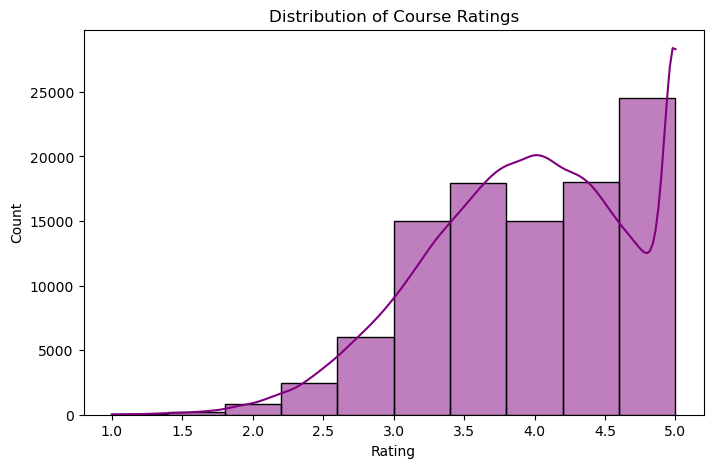

In [ ]:
#1. Histogram of Ratings
plt.figure(figsize=(8,5))
sns.histplot(df['rating'], bins=10, kde=True, color="purple")
plt.title("Distribution of Course Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


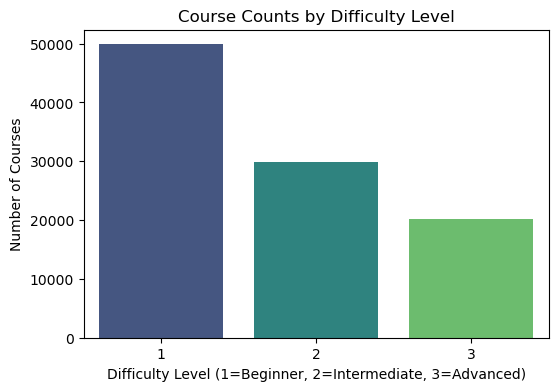

In [ ]:
# 2. Bar Chart of Difficulty Levels
plt.figure(figsize=(6,4))
sns.countplot(x='difficulty_level', data=df, palette="viridis")
plt.title("Course Counts by Difficulty Level")
plt.xlabel("Difficulty Level (1=Beginner, 2=Intermediate, 3=Advanced)")
plt.ylabel("Number of Courses")
plt.show()

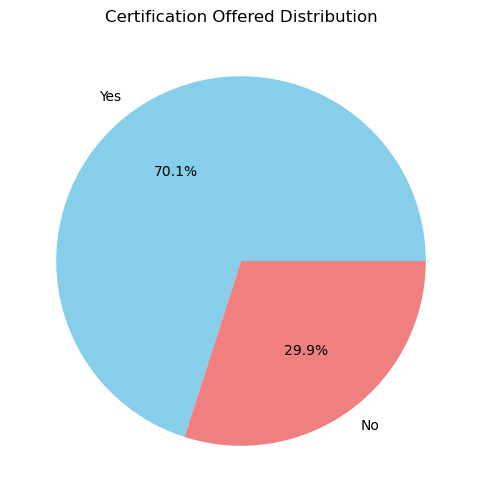

In [ ]:
# 3. Pie Chart of Certification Offered
cert_counts = df['certification_offered'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(cert_counts, labels=['Yes','No'], autopct='%1.1f%%', colors=['skyblue','lightcoral'])
plt.title("Certification Offered Distribution")
plt.show()

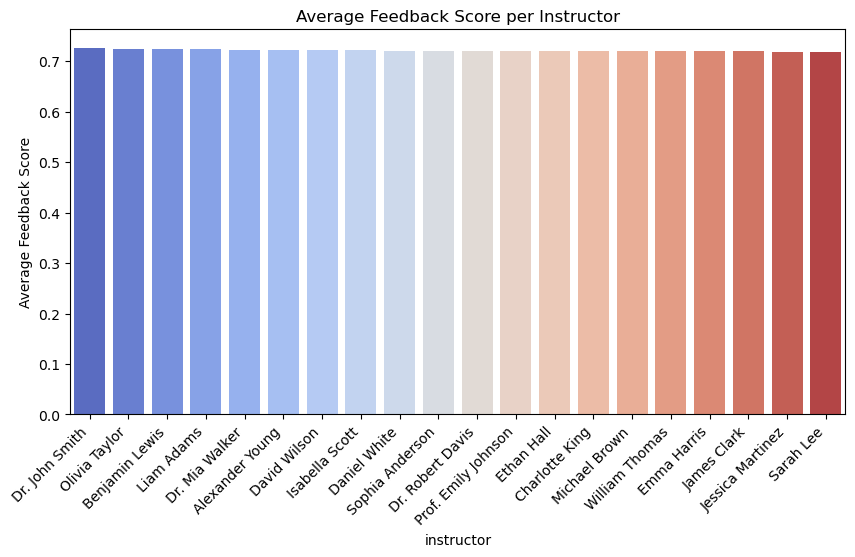

In [ ]:
# 4. Bar Chart of Average Feedback Score per Instructor
avg_feedback = df.groupby('instructor')['feedback_score'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=avg_feedback.index, y=avg_feedback.values, palette="coolwarm")
plt.title("Average Feedback Score per Instructor")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Feedback Score")
plt.show()

In [ ]:
# Select only numeric columns for content-based filtering
numeric_cols = ['difficulty_level', 'course_duration_hours',
                'certification_offered', 'study_material_available',
                'course_price', 'feedback_score']

course_features = df.groupby('course_id')[numeric_cols].mean()



course_sim = cosine_similarity(course_features)
course_sim_df = pd.DataFrame(course_sim, index=course_features.index, columns=course_features.index)


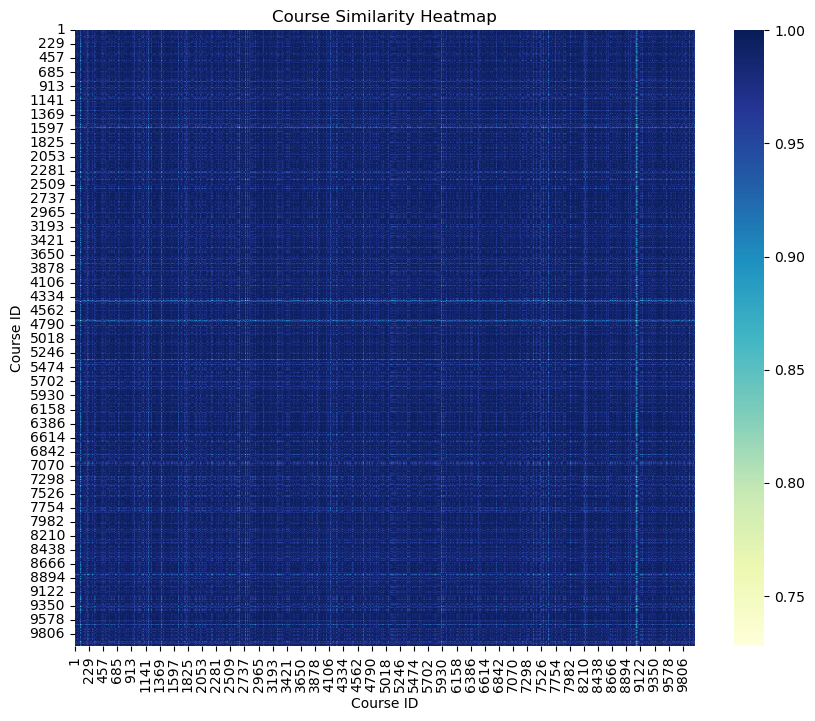

In [ ]:
# Visualization: Course Similarity Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(course_sim_df, cmap="YlGnBu")
plt.title("Course Similarity Heatmap")
plt.xlabel("Course ID")
plt.ylabel("Course ID")
plt.show()

In [ ]:
# Collaborative Filtering
course_avg = df.groupby('course_id')['rating'].mean()

In [ ]:
# Predictions
content_preds = []
for _, row in df.iterrows():
    course_id = row['course_id']
    if course_id in course_sim_df.index:
        similar_courses = course_sim_df[course_id].sort_values(ascending=False)[1:6]
        sim_ratings = df[df['course_id'].isin(similar_courses.index)]['rating']
        pred = sim_ratings.mean() if not sim_ratings.empty else np.nan
    else:
        pred = np.nan
    content_preds.append(pred)

df['content_pred'] = content_preds
df['collab_pred'] = df['course_id'].map(course_avg)

In [ ]:
X = df[['content_pred', 'collab_pred']]
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)

reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
reg_mae = mean_absolute_error(y_test, y_pred)

print("Regression Model Performance:")
print(f"RMSE: {reg_rmse:.3f}, MAE: {reg_mae:.3f}")

Regression Model Performance:
RMSE: 0.700, MAE: 0.571


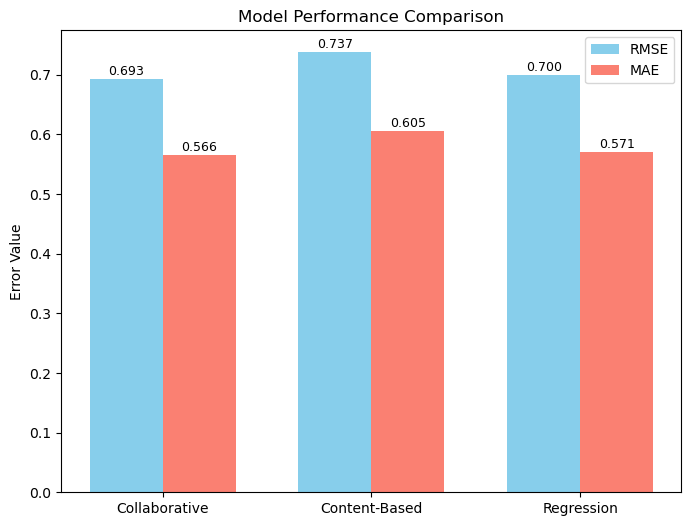

In [ ]:
# Visualization: Model Performance Comparison
models = ["Collaborative", "Content-Based", "Regression"]
rmse_values = [
    np.sqrt(mean_squared_error(df['rating'], df['collab_pred'])),
    np.sqrt(mean_squared_error(df['rating'], df['content_pred'])),
    reg_rmse
]
mae_values = [
    mean_absolute_error(df['rating'], df['collab_pred']),
    mean_absolute_error(df['rating'], df['content_pred']),
    reg_mae
]

x = np.arange(len(models))
width = 0.35
fig, ax = plt.subplots(figsize=(8,6))
rmse_bars = ax.bar(x - width/2, rmse_values, width, label='RMSE', color='skyblue')
mae_bars = ax.bar(x + width/2, mae_values, width, label='MAE', color='salmon')

ax.set_ylabel('Error Value')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

for bars in [rmse_bars, mae_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0,3), textcoords="offset points", ha='center', fontsize=9)
plt.show()

In [ ]:
def recommend_with_regression(user_id, top_n=5):
    rated_courses = df[df['user_id'] == user_id]['course_id'].tolist()
    unrated = df[~df['course_id'].isin(rated_courses)].drop_duplicates('course_id')

    X_unrated = unrated[['content_pred', 'collab_pred']].fillna(course_avg.mean())
    predicted_ratings = reg_model.predict(X_unrated)

    unrated = unrated.copy()
    unrated['predicted_rating'] = predicted_ratings

    top_recs = unrated.sort_values(by='predicted_rating', ascending=False).head(top_n)
    return top_recs[['course_name', 'instructor', 'difficulty_level', 'predicted_rating']]

Sample Recommendations for User 5:
                               course_name           instructor  \
4034       Data Visualization with Tableau        Michael Brown   
41956      Data Visualization with Tableau          Emma Harris   
18256      Data Visualization with Tableau  Prof. Emily Johnson   
78168  Stock Market and Trading Strategies         David Wilson   
6697       Project Management Fundamentals       William Thomas   

       difficulty_level  predicted_rating  
4034                  2          5.002520  
41956                 2          4.800489  
18256                 3          4.800030  
78168                 2          4.733969  
6697                  2          4.730101  


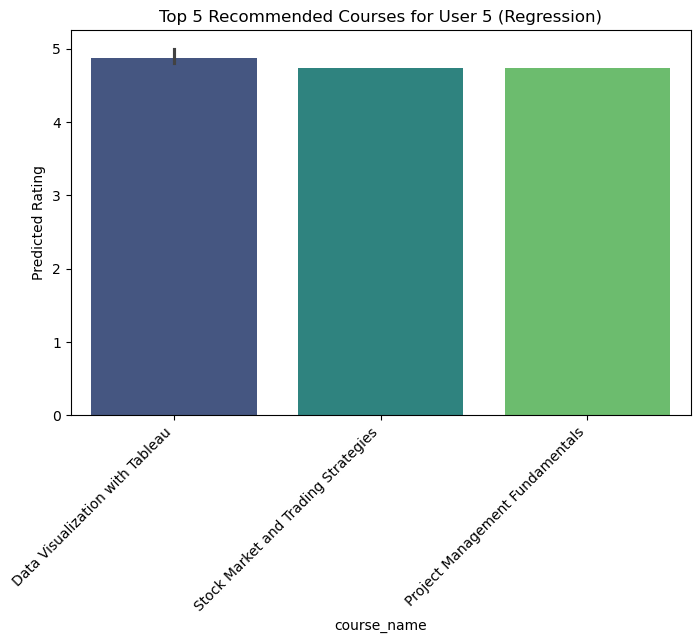

In [ ]:
# Example usage
print("Sample Recommendations for User 5:")
print(recommend_with_regression(user_id=5, top_n=5))

# Visualization: User Recommendations
recs = recommend_with_regression(user_id=5, top_n=5)
plt.figure(figsize=(8,5))
sns.barplot(x=recs['course_name'], y=recs['predicted_rating'], palette="viridis")
plt.title("Top 5 Recommended Courses for User 5 (Regression)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Predicted Rating")
plt.show()